In [1]:
%load_ext RWinOut

In [2]:
%%R
library(caret)
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(pROC)
library(randomForest)
library(gbm)
library(xgboost)
library(AppliedPredictiveModeling)

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from matplotlib import pyplot as plt
%matplotlib inline
import datetime
import pandas as pd
from sklearn import preprocessing as pp
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
%%R
raw.data <- read.csv("E:/Documents/R/mushrooms.csv")
print(sprintf("Number of data rows: %d", nrow(raw.data)))
print(sprintf("Number of data columns: %d", ncol(raw.data)))
df <- read.table("mushrooms.csv")
head(df)

[1] "Number of data rows: 8124"
[1] "Number of data columns: 23"
                                                                                                                                                                                                                                                                                                           V1
1 class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
2                                                                                                                                                                                                                                                               p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
3                            

In [5]:
%%R
class <- plyr::count(raw.data$class)
print(
    sprintf(
        "Edible: %d | Poisonous: %d | Percent of poisonous classes: %.1f%%",
        class$freq[1],
        class$freq[2],
        round(class$freq[1] / nrow(raw.data) * 100, 1)
    )
)

[1] "Edible: 4208 | Poisonous: 3916 | Percent of poisonous classes: 51.8%"


In [6]:
%%R
m.data = raw.data[, 2:23]
m.class = raw.data[, 1]
m.data <- sapply(m.data, function (x)
    as.numeric(as.factor(x)))


In [7]:
%%R
pdf("r1plot.pdf",
    width = 8,
    height = 10,
    paper = 'special')
transparentTheme(trans = .9)
scales <-
    list(
        x = list(relation = "free"),
        y = list(relation = "free"),
        cex = 0.6
    )
gp <- featurePlot(
    x = m.data,
    y = m.class,
    plot = "density",
    scales = scales,
    layout = c(4, 6),
    auto.key = list(columns = 2),
    adjust = 1.5,
    pch = "|"
)
print(gp)
dev.off()

png 
  2 


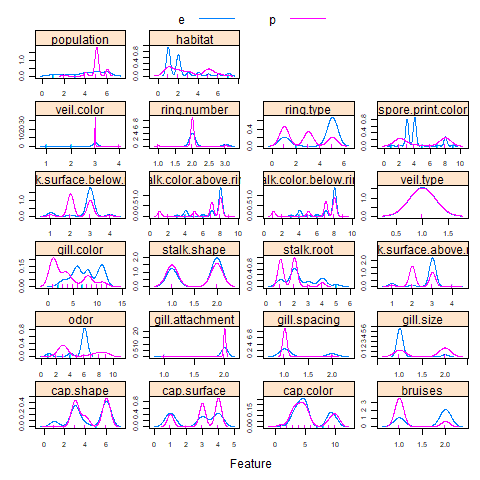

In [8]:
%%R
featurePlot(
    x = m.data,
    y = m.class,
    plot = "density",
    scales = scales,
    layout = c(4, 6),
    auto.key = list(columns = 2),
    adjust = 1.5,
    pch = "|"
)

In [9]:
%%R
df <-
    data.frame(sapply(raw.data, function (x)
        as.numeric(as.factor(x))))
df$class <- df$class - 1
nrows <- nrow(df)
set.seed(314)
indexT <- sample(1:nrow(df), 0.7 * nrows)

In [10]:
%%R
trainset = df[indexT,]
testset =   df[-indexT,]
n <- names(trainset)

rf.form <-
    as.formula(paste("class ~", paste(n[!n %in% "class"], collapse = " + ")))
trainset.rf <-
    randomForest(rf.form, trainset, ntree = 100, importance =
                     T)

In [11]:
%%R
varimp <- data.frame(trainset.rf$importance)

In [12]:
%%R
pdf("r2plot.pdf",
    width = 8,
    height = 10,
    paper = 'special')
transparentTheme(trans = .9)
vi1 <-
    ggplot(varimp, aes(x = reorder(rownames(varimp), IncNodePurity), y = IncNodePurity)) +
    geom_bar(stat = "identity",
             fill = "red",
             colour = "black") +
    coord_flip() + theme_bw(base_size = 8) +
    labs(
        title = "Prediction using RandomForest with 100 trees",
        subtitle = "Variable
 importance (IncNodePurity)",
        x = "Variable",
        y = "Variable importance (IncNodePurity)"
    )
vi2 <-
    ggplot(varimp, aes(x = reorder(rownames(varimp), X.IncMSE), y = X.IncMSE)) +
    geom_bar(stat = "identity",
             fill = "blue",
             colour = "black") +
    coord_flip() + theme_bw(base_size = 8) +
    labs(
        title = "Prediction using RandomForest with 100 trees",
        subtitle = "Variable importance (%IncMSE)",
        x = "Variable",
        y = "Variable importance (%IncMSE)"
    )
gp <- grid.arrange(vi1, vi2, ncol = 2)
print(gp)
dev.off()

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
png 
  2 


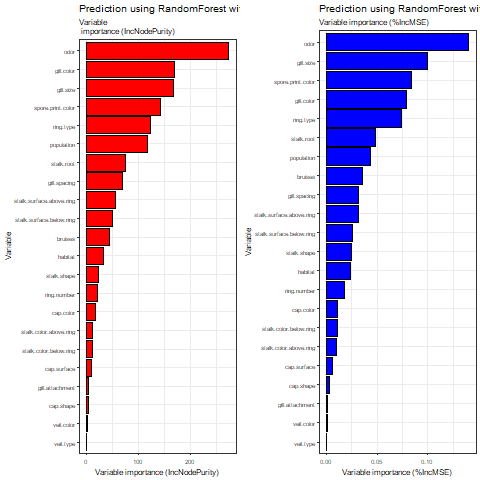

In [13]:
%%R
grid.arrange(vi1, vi2, ncol = 2)

In [14]:
%%R
testset$predicted <- round(predict(trainset.rf , testset), 0)
testset_rf <- testset$predicted

In [15]:
%%R
tst <- data.frame(testset$predicted, testset$class)
opts <- c("Predicted", "True")
names(tst) <- opts
cf <- plyr::count(tst)
cf[opts][cf[opts] == 0] <- "P"
cf[opts][cf[opts] == 1] <- "E"
pdf("r3plot.pdf",
    width = 8,
    height = 10,
    paper = 'special')
transparentTheme(trans = .9)
gp <- ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(title = "Confusion matrix", subtitle = "Prediction using RandomForest with 100 trees") +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")
print(gp)
dev.off()

png 
  2 


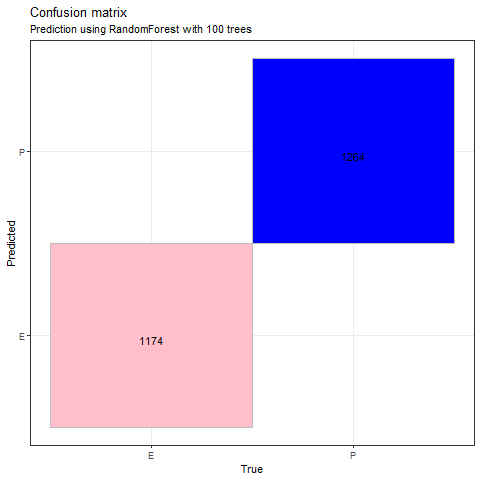

In [16]:
%%R
ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(title = "Confusion matrix", subtitle = "Prediction using RandomForest with 100 trees") +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")

In [17]:
%%R
print(confusionMatrix(factor(testset$class), factor(testset$predicted)))
print(sprintf(
    "Area under curve (AUC) : %.3f",
    auc(testset$class, testset$predicted)
))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1264    0
         1    0 1174
                                     
               Accuracy : 1          
                 95% CI : (0.9985, 1)
    No Information Rate : 0.5185     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.5185     
         Detection Rate : 0.5185     
   Detection Prevalence : 0.5185     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     
[1] "Area under curve (AUC) : 1.000"


In [18]:
%%R
n <- names(trainset)
gbm.form <-
    as.formula(paste("class ~", paste(n[!n %in% "class"], collapse = " + ")))
gbmCV = gbm(
    formula = gbm.form,
    distribution = "bernoulli",
    data = trainset,
    n.trees = 500,
    shrinkage = .1,
    n.minobsinnode = 15,
    cv.folds = 5,
    n.cores = 1
)


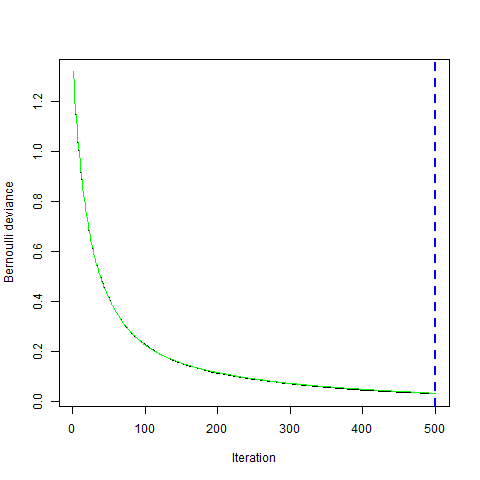

In [19]:
%%R
optimalTreeNumberPredictionCV = gbm.perf(gbmCV)
gbmTest = predict(
    object = gbmCV,
    newdata = testset,
    n.trees = optimalTreeNumberPredictionCV,
    type = "response"
)
testset$predicted <- round(gbmTest, 0)
testset_gbm <- testset$predicted


In [20]:
%%R
tst <- data.frame(testset$predicted, testset$class)
opts <- c("Predicted", "True")
names(tst) <- opts
cf <- plyr::count(tst)
cf[opts][cf[opts] == 0] <- "P"
cf[opts][cf[opts] == 1] <- "E"
pdf("r4plot.pdf",
    width = 8,
    height = 10,
    paper = 'special')
transparentTheme(trans = .9)
gp <- ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(
        title = "Confusion matrix",
        subtitle = sprintf(
            "Prediction using GBM (%d trees)",
            optimalTreeNumberPredictionCV
        )
    ) +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")
print(gp)
dev.off()


png 
  2 


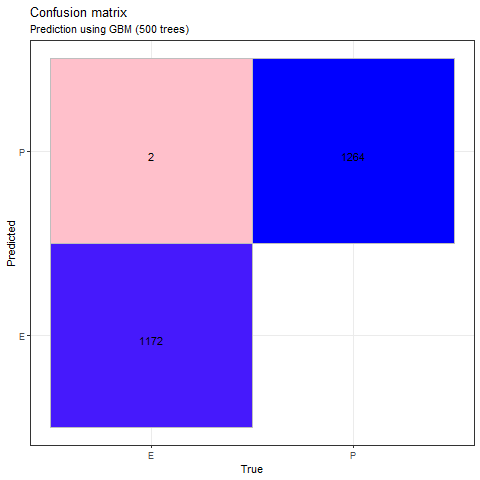

In [21]:
%%R
ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(
        title = "Confusion matrix",
        subtitle = sprintf(
            "Prediction using GBM (%d trees)",
            optimalTreeNumberPredictionCV
        )
    ) +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")

In [22]:
%%R
print(confusionMatrix(factor(testset$class), factor(testset$predicted)))
print(sprintf(
    "Area under curve (AUC) : %.3f",
    auc(testset$class, testset$predicted)
))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1264    0
         1    2 1172
                                         
               Accuracy : 0.9992         
                 95% CI : (0.997, 0.9999)
    No Information Rate : 0.5193         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9984         
                                         
 Mcnemar's Test P-Value : 0.4795         
                                         
            Sensitivity : 0.9984         
            Specificity : 1.0000         
         Pos Pred Value : 1.0000         
         Neg Pred Value : 0.9983         
             Prevalence : 0.5193         
         Detection Rate : 0.5185         
   Detection Prevalence : 0.5185         
      Balanced Accuracy : 0.9992         
                                         
       'Positive' Class : 0              
                                         
[1

In [23]:
%%R
dMtrain <-
    xgb.DMatrix(as.matrix(trainset %>% select(-class)), label = trainset$class)
dMtest <-
    xgb.DMatrix(as.matrix(testset %>% select(-class, -predicted)), label = testset$class)

params <- list(
    "objective"           = "binary:logistic",
    "eval_metric"         = "auc",
    "eta"                 = 0.012,
    "subsample"           = 0.8,
    "max_depth"           = 8,
    "colsample_bytree"    = 0.9,
    "min_child_weight"    = 5
)


In [24]:
%%R
nRounds <- 5000
earlyStoppingRound <- 100
printEveryN = 100
model_xgb.cv <- xgb.cv(
    params = params,
    data = dMtrain,
    maximize = TRUE,
    nfold = 5,
    nrounds = nRounds,
    nthread = 3,
    early_stopping_round = earlyStoppingRound,
    print_every_n = printEveryN
)

[1]	train-auc:0.997978+0.000280	test-auc:0.997490+0.001169 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 100 rounds.

[101]	train-auc:0.999903+0.000007	test-auc:0.999896+0.000077 
Stopping. Best iteration:
[60]	train-auc:0.999907+0.000017	test-auc:0.999910+0.000059



In [25]:
%%R
model_xgb <- xgboost(
    params = params,
    data = dMtrain,
    maximize = TRUE,
    nrounds = nRounds,
    nthread = 3,
    early_stopping_round = earlyStoppingRound,
    print_every_n = printEveryN
)


[1]	train-auc:0.999340 
Will train until train_auc hasn't improved in 100 rounds.

[101]	train-auc:0.999909 
Stopping. Best iteration:
[9]	train-auc:0.999912



In [26]:
%%R
testset$predicted <- round(predict(model_xgb , dMtest), 0)
testset_xgboost <- testset$predicted

In [27]:
%%R
tst <- data.frame(testset$predicted, testset$class)
opts <- c("Predicted", "True")
names(tst) <- opts
cf <- plyr::count(tst)
cf[opts][cf[opts] == 0] <- "P"
cf[opts][cf[opts] == 1] <- "E"
pdf("r5plot.pdf",
    width = 8,
    height = 10,
    paper = 'special')
transparentTheme(trans = .9)
gp <- ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(title = "Confusion matrix",
         subtitle = sprintf("Prediction using XGBoost")) +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")
print(gp)
dev.off()

png 
  2 


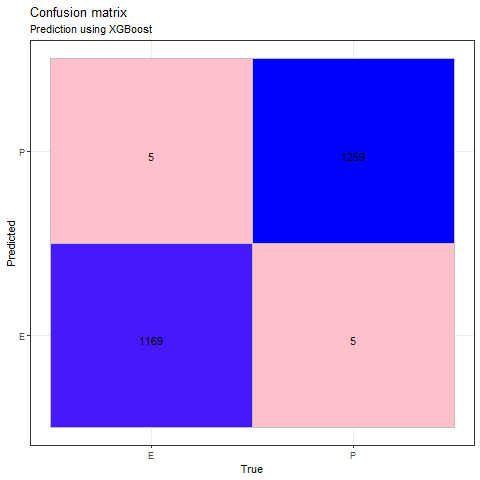

In [28]:
%%R
ggplot(data =  cf, mapping = aes(x = True, y = Predicted)) +
    labs(title = "Confusion matrix",
         subtitle = sprintf("Prediction using XGBoost")) +
    geom_tile(aes(fill = freq), colour = "grey") +
    geom_text(aes(label = sprintf("%1.0f", freq)), vjust = 1) +
    scale_fill_gradient(low = "pink", high = "blue") +
    theme_bw() + theme(legend.position = "none")

In [29]:
%%R
print(confusionMatrix(factor(testset$class), factor(testset$predicted)))
print(sprintf(
    "Area under curve (AUC) : %.3f",
    auc(testset$class, testset$predicted)
))


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1259    5
         1    5 1169
                                         
               Accuracy : 0.9959         
                 95% CI : (0.9925, 0.998)
    No Information Rate : 0.5185         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9918         
                                         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9960         
            Specificity : 0.9957         
         Pos Pred Value : 0.9960         
         Neg Pred Value : 0.9957         
             Prevalence : 0.5185         
         Detection Rate : 0.5164         
   Detection Prevalence : 0.5185         
      Balanced Accuracy : 0.9959         
                                         
       'Positive' Class : 0              
                                         
[1

In [30]:
ds = pd.read_csv('mushrooms.csv')
dat = ds.values

print(dat.shape)

headers = list(ds.columns.values) 

(8124, 23)


In [31]:
#Data Preprocessing
l = pp.LabelEncoder()
l.fit(dat[:, 0])
dataa = l.transform(dat[:, 0])

for ix in range(1, dat.shape[1]):
    le = pp.LabelEncoder()
    le.fit(dat[:, ix])
    y = le.transform(dat[:, ix])
    dataa = np.vstack((dataa , y))
    
data = dataa.T

cate = data[:, 0] #One hot encoding for Neural Network implementation

print(data.shape)

(8124, 23)


In [46]:
split = int(0.80 * data.shape[0])

x_train = data[:split , 1:]
y_train = data[:split, 0]

x_test = data[split: , 1:]
y_test = data[split: , 0]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6499, 22) (6499,)
(1625, 22) (1625,)


In [47]:
y = np_utils.to_categorical(cate)
Y_train = y[:split]
Y_test = y[split:]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)
print(data.shape)

(6499, 22) (1625, 22)
(6499,) (1625,)
(8124, 23)


In [53]:
model = Sequential()

model.add(Dense(22, input_shape=(22,)))
model.add(Activation('relu'))

model.add(Dense(22))
model.add(Activation('relu'))


model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 22)                506       
_________________________________________________________________
activation_12 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 22)                506       
_________________________________________________________________
activation_13 (Activation)   (None, 22)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 46        
_________________________________________________________________
activation_14 (Activation)   (None, 2)                 0         
Total params: 1,058
Trainable params: 1,058
Non-trainable params: 0
_________________________________________________________________


In [54]:
hist = model.fit(x_train, Y_train,
         epochs=100,
         shuffle=True,
         batch_size=128,
         validation_data=(x_test, Y_test))

Train on 6499 samples, validate on 1625 samples
Epoch 1/100
6499/6499 [==============================] - 0s 52us/step - loss: 0.7147 - acc: 0.6136 - val_loss: 0.4162 - val_acc: 0.8782
Epoch 2/100
6499/6499 [==============================] - 0s 7us/step - loss: 0.5013 - acc: 0.7653 - val_loss: 0.2321 - val_acc: 0.9151
Epoch 3/100
6499/6499 [==============================] - 0s 6us/step - loss: 0.4009 - acc: 0.8377 - val_loss: 0.1956 - val_acc: 0.9680
Epoch 4/100
6499/6499 [==============================] - 0s 6us/step - loss: 0.3195 - acc: 0.8851 - val_loss: 0.1668 - val_acc: 0.9711
Epoch 5/100
6499/6499 [==============================] - 0s 6us/step - loss: 0.2518 - acc: 0.9108 - val_loss: 0.1656 - val_acc: 0.9606
Epoch 6/100
6499/6499 [==============================] - 0s 7us/step - loss: 0.1979 - acc: 0.9238 - val_loss: 0.1822 - val_acc: 0.9446
Epoch 7/100
6499/6499 [==============================] - 0s 7us/step - loss: 0.1539 - acc: 0.9400 - val_loss: 0.1995 - val_acc: 0.9311
Epoch 

6499/6499 [==============================] - 0s 6us/step - loss: 6.4062e-04 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9785
Epoch 61/100
6499/6499 [==============================] - 0s 6us/step - loss: 6.3906e-04 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9754
Epoch 62/100
6499/6499 [==============================] - 0s 7us/step - loss: 6.0251e-04 - acc: 1.0000 - val_loss: 0.1074 - val_acc: 0.9735
Epoch 63/100
6499/6499 [==============================] - 0s 6us/step - loss: 6.0943e-04 - acc: 1.0000 - val_loss: 0.1032 - val_acc: 0.9760
Epoch 64/100
6499/6499 [==============================] - 0s 6us/step - loss: 5.3400e-04 - acc: 1.0000 - val_loss: 0.0957 - val_acc: 0.9778
Epoch 65/100
6499/6499 [==============================] - 0s 6us/step - loss: 5.3176e-04 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9723
Epoch 66/100
6499/6499 [==============================] - 0s 6us/step - loss: 5.1329e-04 - acc: 1.0000 - val_loss: 0.0990 - val_acc: 0.9785
Epoch 67/100
6499/6499 [=========

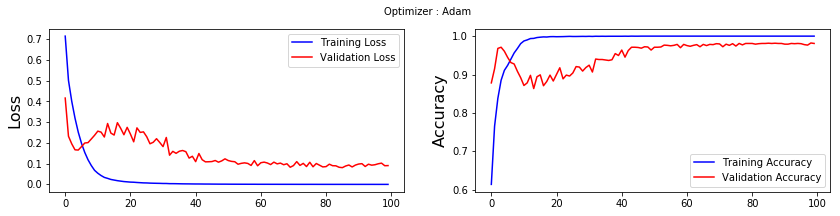

In [55]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc

#Predict on test set
predictions_NN_prob = model.predict(x_test)
predictions_NN_prob = predictions_NN_prob[:,0]

predictions_NN_01 = np.where(predictions_NN_prob < 0.5, 1, 0) #Turn probability to 0-1 binary output



In [57]:
#Print accuracy
acc_NN = accuracy_score(y_test, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN)

Overall accuracy of Neural Network model: 0.9809230769230769
